<a href="https://colab.research.google.com/github/hudada369/fy2020-repo-config/blob/master/Pytorch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Pytorch的计算图机制和自动求导机制**

### **一：计算图的概念，动态图与静态图的差异和搭建过程**
1. 比如多个操作之间该并行还是顺序执行，底层的设备如何协同，如何避免冗余的操作等
2. 计算图是用来「描述运算」的有向无环图。主要有两个因素：节点和边。其中节点表示数据，如向量，矩阵，张量，而边表示运算，如加减乘除 [2.]可以不用设定dtype
  节点.data , 节点.grad 可以直接查看
  1. 张量的属性：叶节点，在反向传播中，非叶子节点的梯度是随时释放的, 如果想用非叶子节点这里面的某个梯度呢？比如我想保留a的梯度，那么可以使用 retain_grad() 方法。就是在**执行反向传播之前，执行一行代码：a.retain_grad()** 即可。
  2. grad_fn：记录创建该张量时所用的方法（函数），记录这个方法主要「用于梯度的求导」
  3. requires_grad=True 在定义是用来确定是否需要被求导

In [ ]:
import torch
# 利用计算图计算 y=(x+w)*(w+1),利用图计算可以用来方便进行反向传播计算
w = torch.tensor([1.],requires_grad=True)
x = torch.tensor([2.],requires_grad=True)

a = torch.add(w,x)
b = torch.add(w,1)
y = torch.mul(a,b)
a.retain_grad()

y.backward()
print(w.grad) # [5.]

# 查看节点是否是叶子节点 以及 梯度值
#查看叶子结点
print("is_leaf:\n", w.is_leaf, x.is_leaf, a.is_leaf, b.is_leaf, y.is_leaf)
#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)
# 查看节点的计算函数
print("cal:\n", w.grad_fn,a.grad_fn)

tensor([5.])
is_leaf:
 True True False False False
gradient:
 tensor([5.]) tensor([2.]) tensor([2.]) None None
cal:
 None <AddBackward0 object at 0x7fde7383c510>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


二：计算图的搭建
  按照计算图的搭建方式，分为动态图和静态图
1. 静态图：先搭建图，后运算。高效，不灵活（TensorFlow）：
  1. TensorFlow 的计算方式，是先把图搭建好，然后开启**一个会话**， 在那里面才开始喂入数据进行流动计算， 在这个过程中，张量就会根据搭建好的图进行计算
2. 动态图：运算与搭建同时进行。灵活，易调节（Pytorch）：
  1. Pytorch 就是采用的这种机制，这种机制就是**边建图边执行**

In [ ]:
import tensorflow as tf
# 声明两个常量
w = tf.constant(1.)
x = tf.constant(2.)

# 搭建静态图
a = tf.add(w, x)
b = tf.add(w, 1)
y = tf.multiply(a, b)

# 这时候还没开始计算
print(y)   # Tensor("Mul_4:0", shape=(), dtype=float32)， 只是计算图的一个节点

with tf.compat.v1.Session() as sess:  
    sess.run(y)   # 这里才开始进行计算， 6.0

tf.Tensor(6.0, shape=(), dtype=float32)


RuntimeError: ignored

三：自动求导机制
1. Pytorch 自动求导机制使用的是 torch.autograd.backward(tensor,grad_tensors=None,retain_grah=None,create_graph=False)
  1. tensors 表示用于求导的张量，如 loss。
  2. retain_graph 表示保存计算图， 由于 Pytorch 采用了动态图机制，在每一次反向传播结束之后，计算图都会被释放掉（计算一次之后就没了）。如果我们不想被释放，就要设置这个参数为 True
  3. create_graph 表示创建导数计算图，用于高阶求导。
  4. grad_tensors 表示多梯度权重。如果有多个 loss 需要计算梯度的时候，就要设置这些 loss 的权重比例，具体看示例
2.  backwrad函数是在调用autograd函数
  1. def backward(self, gradient=None, retain_graph=None, create_graph=False):
     torch.autograd.backward(self, gradient, retain_graph, create_graph)
3. torch.autograd.grad()， 这个方法的功能是求取梯度，这个可以实现高阶的求导
  1. torch.autograd.grad(outputs,inputs,grad_ouputs=None,retain_graph=None,create_graph=False)
  2. outputs: 用于求导的张量，如 loss
    2. inputs: 需要梯度的张量，如上面例子的 w 
    3. create_graph: 创建导数计算图，用于高阶求导
    4. retain_graph: 保存计算图
    5. grad_outputs: 多梯度权重

In [ ]:
w = torch.tensor([1.],requires_grad=True)
x = torch.tensor([2.],requires_grad=True)

a = torch.add(w,x)
b = torch.add(w,1)
y0 = torch.mul(a,b)
y1 = torch.add(a,b)
loss = torch.cat([y0,y1],dim=0)
# loss.backward() 这个时候对w求导，会有两个梯度，直接求导会报错
# 用到了 grad_tensors 对梯度设置权重, backward中的gradient参数
grad_t = torch.tensor([1.,1.])
loss.backward(gradient = grad_t)
print(w.grad) # tensor([7.])
grad_t = torch.tensor([1.,2.])
loss.backward(gradient = grad_t)
print(w.grad) #tensor([9.])
# 权重不同，结果不同

tensor([9.])


In [ ]:
# 对函数 torch.autograd.grad() 解释
x = torch.tensor([3.],requires_grad=True)
y = torch.pow(x, 2)
# 一次求导 create_graph 高阶求导，也就是求导一次之后不会消失
gead_1 = torch.autograd.grad(y,x,create_graph=True)
print(gead_1) ## (tensor([6.], grad_fn=<MulBackward0>),) 这是个元组，二次求导的时候我们需要第一部分
# 返回的是元祖表示
grad_2 = torch.autograd.grad(gead_1,x)
print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


In [ ]:
# 多个因变量的torch.autograd.grad解释
x1 = torch.tensor(1.0,requires_grad = True) # x需要被求导
x2 = torch.tensor(2.0,requires_grad = True)

y1 = x1*x2
y2 = x1+x2


# 允许同时对多个自变量求导数
(dy1_dx1,dy1_dx2) = torch.autograd.grad(outputs=y1,inputs = [x1,x2],retain_graph = True)
print(dy1_dx1,dy1_dx2)        # tensor(2.) tensor(1.)

# 如果有多个因变量，相当于把多个因变量的梯度结果求和
(dy12_dx1,dy12_dx2) = torch.autograd.grad(outputs=[y1,y2],inputs = [x1,x2])
print(dy12_dx1,dy12_dx2)        # tensor(3.) tensor(2.)

tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


pytorch的自动求导注意的是：
 1. 梯度不自动清零：就是每一次反向传播，梯度都会叠加上去，每一次反向传播之后，我们「要手动的清除梯度」
   1. w.grad.zero_(), 有个下划线，这个代表原位操作
 2. 依赖于叶子节点的节点，requires_grad 默认为 True
 3. 叶子节点不可执行 in-place（这个 in-place 就是原位操作） 首先先看看什么是 in-place 操作， 这个操作就是在原始内存当中去改变这个数据, 例如数字字符串，对其操作之后，其实两次指向的对象是不一样的, 例如a=5,a=a+1,那么第二次a指向的位置不是同一个，原位操作是a+=1  叶子节点不可操作的是：在反向传播的时候，非叶节点求导如果用到叶节点的值，那么会提前保存叶节点的内存位置，如果叶节点的值改变，那么就不能被利用

In [ ]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)
    w.grad.zero_()
# 不清零 梯度值 tensor([20.])

w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)

y = torch.mul(a, b)    # y0=(x+w) * (w+1)     dy0 / dw = 5
print(w.requires_grad, a.requires_grad, b.requires_grad)  # 这里会都是True， w的我们设置了True， 而后面这里是依赖于叶子，所以默认是True


tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])
True True True


In [ ]:
a = torch.ones((1,))
print(id(a), a)    # 1407221517192 tensor([1.])

# 我们执行普通的a = a+1操作
a = a + torch.ones((1,))
print(id(a), a)    # 1407509388808 tensor([2.])  
# 会发现上面这两个a并不是同一个内存空间

# 那么执行原位操作呢？
a = torch.ones((1,))
print(id(a), a)    # 2112218352520 tensor([1.])
a += torch.ones((1,))
print(id(a), a)   # 2112218352520 tensor([2.])

140593397505104 tensor([1.])
140593397060624 tensor([2.])
140593397558640 tensor([1.])
140593397558640 tensor([2.])


In [ ]:
# 叶子节点原位操作
x = torch.tensor([1.],requires_grad=True)
y = torch.tensor([2.],requires_grad=True)

w.add_(1)


RuntimeError: ignored

In [2]:
# 机器学习模型训练步骤： 数据 模型 损失函数 优化器 迭代训练
# 逻辑回归模型

# 数据生产
import torch
torch.manual_seed(1)
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums,2)

#生成两类样本，每个样本两个特征
x0 = torch.normal(mean_value*n_data,1) + bias # 类别0 数据shape(100,2)
y0 = torch.zeros(sample_nums)
x1 = torch.normal(-mean_value*n_data,1)+bias
y1 = torch.ones(sample_nums)

train_x = torch.cat([x0,x1],0)
train_y = torch.cat([y0,y1],0)

In [3]:
 # 建立模型，一种是 pytorch的sequential方式搭积木 一种是继承nn.Module这个类搭建模型
class LR(torch.nn.Module):
   def __init__(self):
     super(LR,self).__init__()
# Linear 是module的子类，是参数化module的一种，与其名称一样，表示着一种线性变换。输入2个节点，输出1个节点
     self.features = torch.nn.Linear(2,1)
     self.sigmoid = torch.nn.Sigmoid()
   def forward(self,x):
     x = self.features(x)
     x = self.sigmoid(x)
     return x
lr_net = LR() # 实例化逻辑回归模型 

In [ ]:
# 另外一种构建的方法会死
lr_net = torch.nn.Sequential(
   torch.nnn.Linear(2,1),
   torch.nn.Sigmoid() 
)

In [4]:
# 损失函数 二进制的交叉熵损失函数
loss_fn = torch.nn.BCELoss()
# 优化器  SGD优化器 随机梯度下降
lr = 0.01
optimizer = torch.optim.SGD(lr_net.parameters(),
            lr=lr,momentum=0.9)

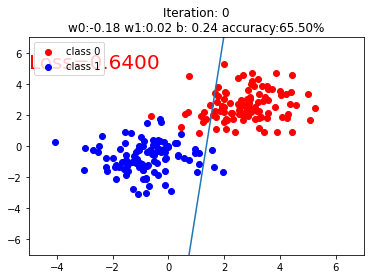

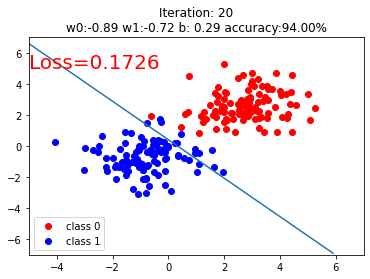

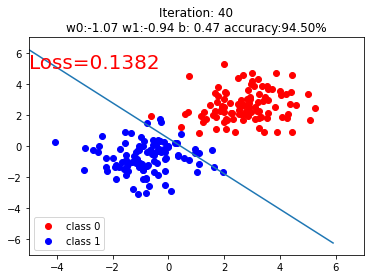

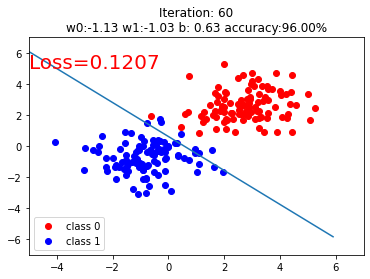

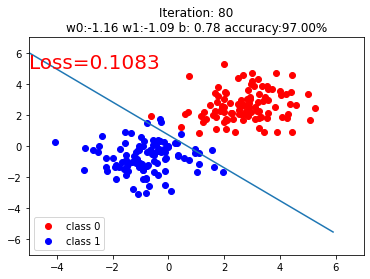

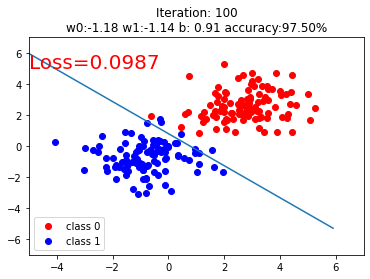

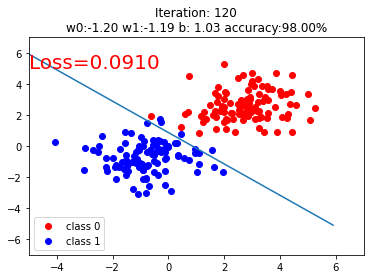

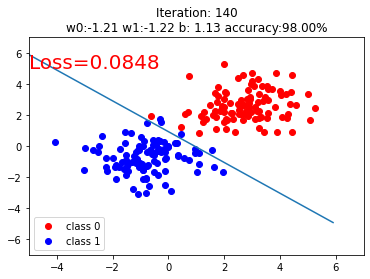

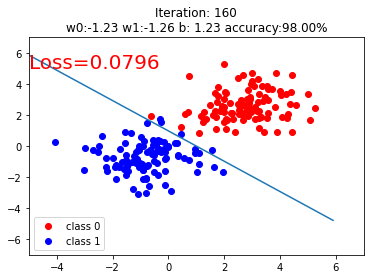

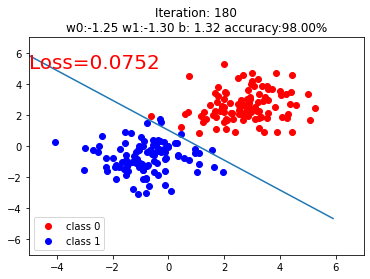

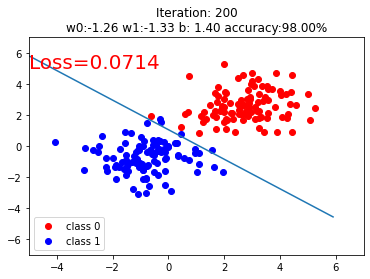

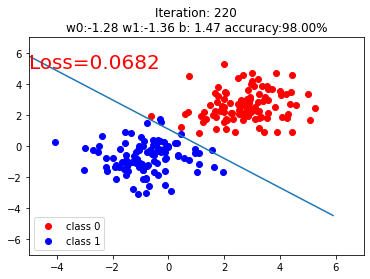

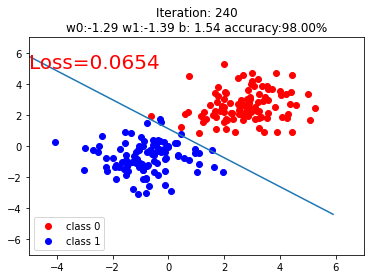

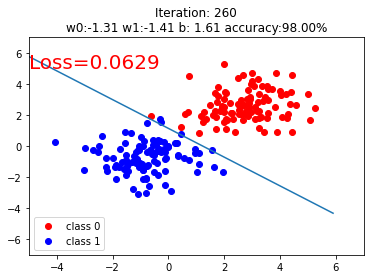

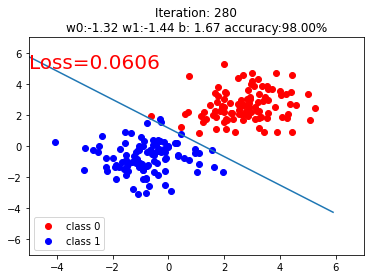

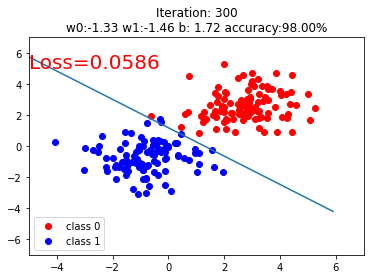

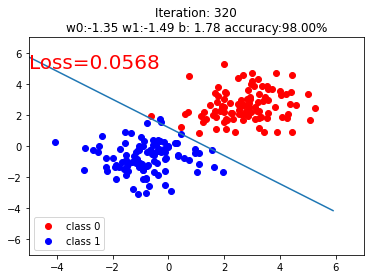

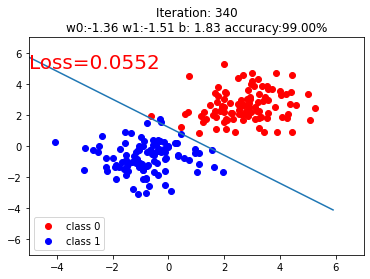

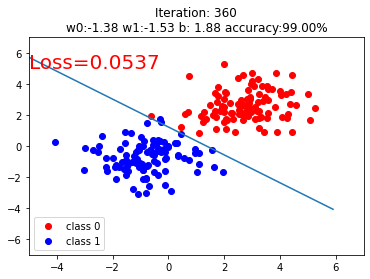

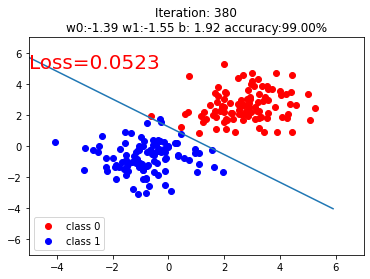

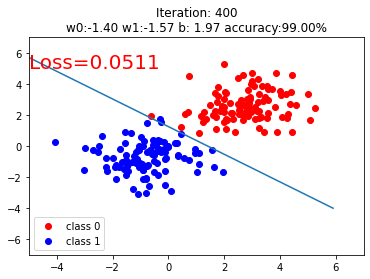

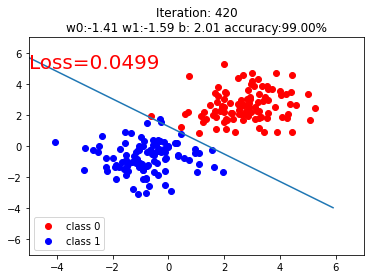

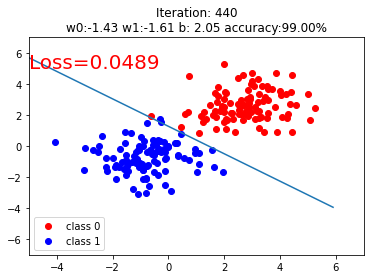

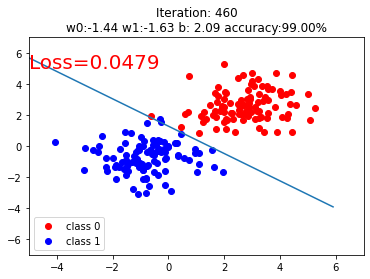

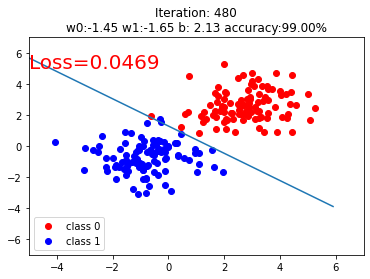

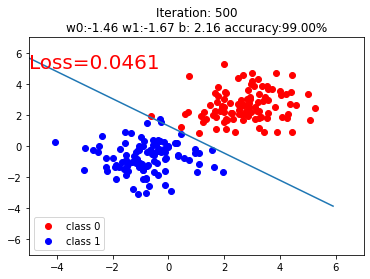

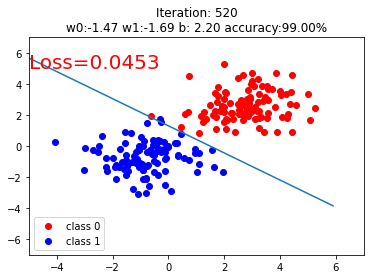

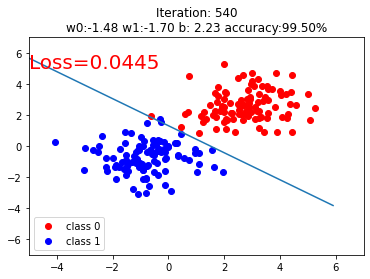

In [11]:
# 迭代训练 过程：前向传播-计算梯度-反向传播-更新参数-梯度清零
import matplotlib.pyplot as plt
import numpy as np
for iteration in range(1000):
  # 前向传播
  y_pred = lr_net(train_x)

  #loss
  loss = loss_fn(y_pred.squeeze(),train_y)

  # 反向传播
  loss.backward()
  # 更新参数
  optimizer.step()
  # 清空梯度
  optimizer.zero_grad()

  # 绘图
  if iteration % 20 == 0:
    # # 以0.5为阈值进行分类
    mask = y_pred.ge(0.5).float().squeeze()
    correct = (mask==train_y).sum()  # 计算正确预测的样本个数 
    # 计算分类准确率
    acc = correct.item() / train_y.size(0)
    plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
    plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')
    w0,w1 = lr_net.features.weight[0] # 拿到线性模型的权重
    w0,w1 = float(w0.item()),float(w1.item()) 
    plot_b = float(lr_net.features.bias[0].item()) # 拿到线性模型的偏置
    plot_x = np.arange(-6, 6, 0.1)
    plot_y = (-w0 * plot_x - plot_b) / w1
    plt.xlim(-5, 7)
    plt.ylim(-7, 7)
    plt.plot(plot_x, plot_y)

    plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
    plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
    plt.legend()

    plt.show()
    plt.pause(0.5)

    if acc > 0.99:
        break
